In [1]:
from PIL import Image
from PIL import ImageDraw

from torch.utils.data import DataLoader

from inpainting import transforms
from inpainting.load import MergeDataset, SequenceDataset
from inpainting.utils import dilate_mask, annotation_to_mask, tensor_to_pil_image, get_paths, mask_to_bbox

In [2]:
images_dataset = SequenceDataset(
    get_paths(f'../data/interim/demo/Images/breakdance'),
    'image',
    sequence_length=1,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)
masks_dataset = SequenceDataset(
    get_paths(f'../data/interim/demo/Annotations/breakdance'),
    'annotation',
    sequence_length=1,
    transform=transforms.Compose([
        transforms.Lambda(lambda x: annotation_to_mask(x, object_id=[1, 2])),
        transforms.ToTensor()
    ])
)
dataset = MergeDataset([images_dataset, masks_dataset])
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

In [3]:
images, masks = next(iter(data_loader))
image, mask = images[0].cuda(), masks[0].cuda()

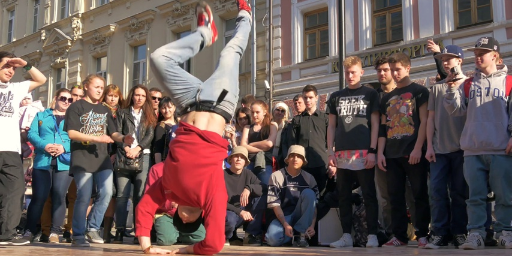

In [4]:
tensor_to_pil_image(image)

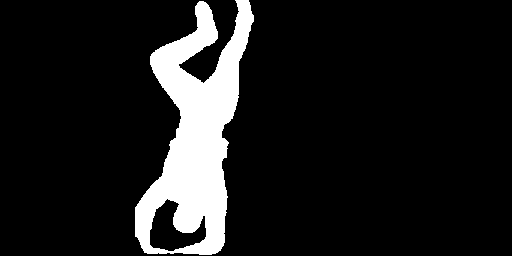

In [5]:
tensor_to_pil_image(mask)

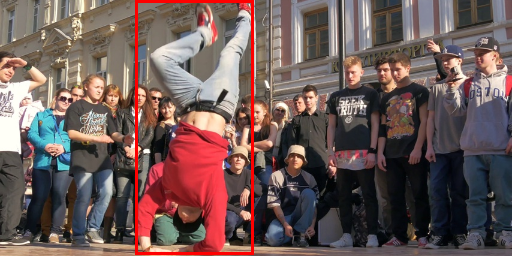

In [6]:
bbox = mask_to_bbox(masks[0])
image_with_bbox = tensor_to_pil_image(image)
ImageDraw.Draw(image_with_bbox).rectangle(bbox, outline="red", width=3)
image_with_bbox

In [7]:
def visualize(image, mask):
    pil_image = tensor_to_pil_image(image)
    pil_mask = tensor_to_pil_image(mask)

    pil_image = pil_image.convert('RGBA')
    pil_overlay = Image.new('RGBA', pil_image.size, (255,255,255,0))
    draw = ImageDraw.Draw(pil_overlay)
    draw.bitmap((0, 0), pil_mask, (255, 0, 0, 128))
    pil_result = Image.alpha_composite(pil_image, pil_overlay)
    return pil_result

C:\Users\jakub\anaconda3\envs\inpainting\lib\site-packages\torch\nn\functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


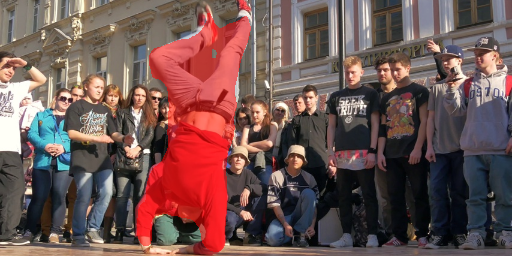

In [8]:
from inpainting.tracking.siammask.model import SiamMaskModel

model = SiamMaskModel(
    config_path='../models/tracking/siammask/config_davis.json',
    weights_path='../models/tracking/siammask/SiamMask_DAVIS.pth'
).cuda()
model.initialize(image, mask_to_bbox(mask))
result = model.forward(image)
visualize(image, result)

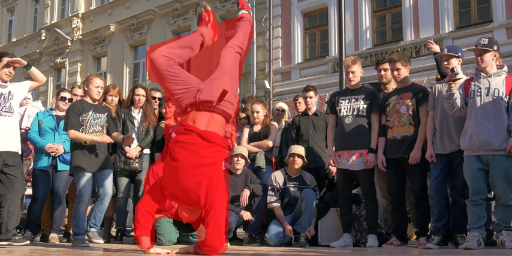

In [9]:
visualize(image, dilate_mask(result, 3, 3))

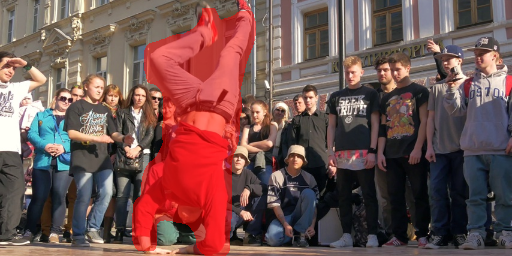

In [10]:
visualize(image, dilate_mask(result, 3, 5))

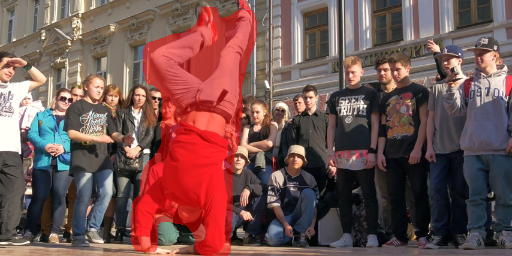

In [11]:
visualize(image, dilate_mask(result, 5, 3))

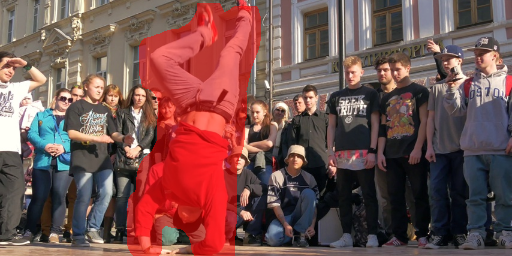

In [12]:
visualize(image, dilate_mask(result, 5, 5))